In [15]:
exp_no = 20
batch_size = _batch_size = 32
nb_classes = _nb_classes = 5
nb_samples_per_class = _nb_samples_per_class = 10
_input_height = _input_width = 40
colorspace = 'L'
channels = {'RGB':3, 'L':1}
_iterations = 100000

img_size = (_input_height, _input_width)
img_shape = [_input_height, _input_width, channels[colorspace]]

input_size = _input_height * _input_width * channels[colorspace]
cell = 'DNC'
nb_reads = _nb_reads = 1
controller_size = _controller_size = 100
memory_size = _memory_locations = 128
memory_dim = ar_memory_word_size = 20
summary_interval = 100
checkpt_write_interval = 1000
dataset = 'omniglot'
splits=[1200,200,0]

learning_rate = _learning_rate = 1e-3
start=0
save_dir='./Experiments_New/Convolutional4layer'
_start_iterations = 0

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from packaging import version
import os
import sys


In [17]:
tf.compat.v1.logging.set_verbosity('DEBUG')

In [18]:
sys.path.append('./metalearning')
os.environ["RECORDS"]="./datasets/Records"

In [19]:
from metalearning_tasks.fixed_shot_classification_v2 import DatasetGenerator
from models.model_builder import create_one_hot_model_convolutional, create_cell

In [20]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_error = tf.keras.metrics.Mean('train_error', dtype=tf.float32)

In [21]:
def metric_accuracy(_nb_classes,_nb_samples_per_class,labels, outputs):
    seq_length = _nb_classes * _nb_samples_per_class
    outputs = np.argmax(outputs, axis=-1)
    correct = [0] * seq_length
    total = [0] * seq_length
    for i in range(np.shape(labels)[0]):
        label = labels[i]
        output = outputs[i]
        class_count = {}
        for j in range(seq_length):
            class_count[label[j]] = class_count.get(label[j], 0) + 1
            total[class_count[label[j]]] += 1
            if label[j] == output[j]:
                correct[class_count[label[j]]] += 1
    return [float(correct[i]) / total[i] if total[i] > 0. else 0.
            for i in range(1, _nb_samples_per_class + 1)]
last_logged_ep=0

@tf.function
def trainstep(model, data_generator, optimizer):
    image, label = data_generator.generate_batch("train",
                                                 _batch_size)
    images = tf.reshape(image, (_batch_size,-1,40,40,3))
    one_hot_target = tf.one_hot(label, _nb_classes, axis=-1)
    offset_target_var = tf.concat([tf.zeros_like(tf.expand_dims(
        one_hot_target[:, 0], 1)), one_hot_target[:, :-1]], axis=1)

    with tf.GradientTape() as tape:
        output = model([images, offset_target_var])
        loss = tf.reduce_mean(
                    tf.reduce_sum(
                        tf.nn.softmax_cross_entropy_with_logits(
                            labels=one_hot_target,
                            logits=output
                        ),
                        axis=1)
                  )
        grads, _ = tf.clip_by_global_norm(
            tape.gradient(loss, model.trainable_variables),
            50)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def train(model, data_genarator, _start_iterations, _iterations, _learning_rate, cell, _batch_size, _nb_classes, save_dir):
    optimizer = tf.keras.optimizers.Adam(lr=_learning_rate)
    print("1st\t2nd\t3rd\t4th\t5th\t6th\t7th\t8th\t9th\t10th\tbatch\tloss\tdt")
    logdir = f"{save_dir}/{dataset}/{cell}/{_learning_rate}/{exp_no}/logs"
    summary_writer = tf.summary.create_file_writer(logdir)
    dt = datetime.now()
    accuracies = []
    losses = []
    for ep in range(_start_iterations, _iterations):
        if ep % summary_interval == 0:
            image, label = data_generator.generate_batch("train",
                                                         _batch_size)
            images = tf.reshape(image, (_batch_size,-1,40,40,3))
            one_hot_target = tf.one_hot(label, _nb_classes, axis=-1)
            offset_target_var = tf.concat([tf.zeros_like(tf.expand_dims(
                one_hot_target[:, 0], 1)), one_hot_target[:, :-1]], axis=1)
            output = model([images, offset_target_var])
            loss = tf.reduce_mean(
                        tf.reduce_sum(
                            tf.nn.softmax_cross_entropy_with_logits(
                                labels=one_hot_target,
                                logits=output),
                            axis=1))
            accuracy = metric_accuracy(_nb_classes, _nb_samples_per_class, label, output)
            accuracies.append((ep,accuracy))
            dt = datetime.now() - dt

            for accu in accuracy:
                print('%.4f' % accu, end='\t')
            print('%d\t%.4f\t%.4f' % (ep, loss, dt.total_seconds()))
            train_loss(loss)
            losses.append((ep,train_loss.result()))

            dt = datetime.now()
        if ep % checkpt_write_interval == 1 and ep > 0:
            model.save_weights(f"{save_dir}/{dataset}/{cell}/{_learning_rate}/{exp_no}" + "/model.")
            with open(f"{save_dir}/{dataset}/{cell}/{_learning_rate}/{exp_no}" + "/model.iteration", 'w') as f:
                _start_iterations =  f.write(str(ep))
            with summary_writer.as_default():
              for ep_idx, accuracy in accuracies:
                for i, accu in enumerate(accuracy):
                    tf.summary.scalar(f'train_acc_{i}',
                                      accu,
                                      step=ep_idx)
              for ep_idx, loss_res in losses:
                tf.summary.scalar('train_loss',
                                  train_loss.result(),
                                  step=ep_idx)
            last_logged_ep=ep
            accuracies=[]
            losses=[]
        loss = trainstep(model, data_generator, optimizer)
        train_loss(loss)


In [22]:
def create_one_hot_model_convolutional(image_size,
                                       extra_channel,
                                       output_size,
                                       batch_size,
                                       cell,
                                       cnn):
    labels = tf.keras.layers.Input([None] + extra_channel,
                                   batch_size=batch_size)
    images = tf.keras.layers.Input([None] + image_size,
                                   batch_size=batch_size)
    labels0 = tf.stop_gradient(labels)
    images0 = tf.stop_gradient(images)
    resnet = tf.keras.applications.EfficientNetB0(
                                                    include_top=False, weights='imagenet',
                                                    input_shape=(40,40,1)
                                                  )
    cnn_timeseries = tf.keras.layers.TimeDistributed(resnet, trainable=False)
    flatten = tf.keras.layers.Flatten()
    flatten_timeseries = tf.keras.layers.TimeDistributed(flatten)
    linear = tf.keras.layers.Dense(400)
    linear_timeseries = tf.keras.layers.TimeDistributed(linear)
    cell = create_cell(cell,
                       output_size,
                       100,
                       128,
                       20,
                       10)

    initial_state = cell.get_initial_state(batch_size=batch_size,
                                           dtype=tf.float32)
    rnn = tf.keras.layers.RNN(cell, return_sequences=True)
    cnn_out = cnn_timeseries(images0)
    flatten_out = flatten_timeseries(cnn_out)
    linear_out = linear_timeseries(flatten_out)
    cnn_out_plus_labels = tf.concat([linear_out, labels0], axis=-1)
    y1 = rnn(cnn_out_plus_labels, initial_state=initial_state)
    y2 = tf.keras.layers.Dense(output_size)(y1)
    y3 = tf.keras.layers.Softmax()(y2)
    model = tf.keras.Model([images, labels], y3)
    return model

In [23]:
model = create_one_hot_model_convolutional(img_shape,
                                           [5],
                                           5,
                                           _batch_size,
                                           cell,
                                          '4layerConv')
ds_root = f'./datasets/Records/{dataset}'
data_generator = DatasetGenerator(data_folder=ds_root,
                                  splits=splits,
                                  nb_samples_per_class=nb_samples_per_class,
                                  img_size=img_size,
                                  colorspace=colorspace,
                                  pre_scale=(60,60),
                                  augment=False
                                )

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(32, None, 40, 40,  0                                            
__________________________________________________________________________________________________
tf.stop_gradient_3 (TFOpLambda) (32, None, 40, 40, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (32, None, 2, 2, 128 4049571     tf.stop_gradient_3[0][0]         
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (32, None, 5120)     0           time_distributed_3[0][0]         
____________________________________________________________________________________________

In [25]:
b1 = data_generator.generate_batch('train', _batch_size)

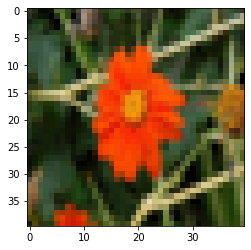

In [26]:
plt.imshow(tf.reshape(b1[0][0,0,:],(40,40,3)))

In [ ]:
train(model, data_generator, _start_iterations, _iterations, _learning_rate, cell, _batch_size, _nb_classes, save_dir)

1st	2nd	3rd	4th	5th	6th	7th	8th	9th	10th	batch	loss	dt
0.1750	0.1875	0.1938	0.1950	0.1962	0.1974	0.2069	0.2180	0.2018	0.2000	0	80.5059	2.0645
0.2062	0.1750	0.1562	0.1875	0.2013	0.2129	0.2260	0.2406	0.2500	0.2414	100	80.7645	95.5806
0.2000	0.1750	0.2250	0.2453	0.1975	0.1667	0.1739	0.1769	0.1712	0.1798	200	80.9198	89.5149
0.1875	0.1812	0.2062	0.2138	0.2500	0.2517	0.2313	0.2154	0.1964	0.2021	300	80.7201	89.8023
0.1875	0.2000	0.1875	0.1812	0.1950	0.1974	0.2113	0.1890	0.1942	0.1829	400	80.7902	89.5185
0.1812	0.1750	0.1875	0.1938	0.1911	0.1933	0.1879	0.2045	0.1810	0.1648	500	80.8365	89.8699
0.1812	0.1812	0.2188	0.1938	0.1859	0.1921	0.1702	0.1694	0.2432	0.2644	600	80.6815	89.6332
0.1938	0.1875	0.2188	0.2313	0.1824	0.1720	0.1533	0.1642	0.1488	0.1613	700	81.0772	89.8304
0.2062	0.2000	0.2062	0.2102	0.2051	0.2053	0.2222	0.2248	0.1802	0.2211	800	80.7881	89.5476
0.1750	0.1750	0.2125	0.2062	0.1887	0.1895	0.1986	0.1628	0.1532	0.1667	900	80.9801	89.7312
0.2188	0.2013	0.2089	0.2675	0.2129	0.1600	0.1667

In [ ]:
tf.autograph.set_verbosity(0)